# **Finding Lane Lines on the Road** 
***
In this project, I created a pipeline to identify the lane lines on the left and right in front of the vehicle, mainly using Canny edge detection and the Hough transform. I test this on a series of individual images, and then apply it to different videos.

**The main function (process_image) takes in an image array and returns the image for display (as below).**

---
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> The goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages for image/array manipulation and display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
%matplotlib inline

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [2]:
# Helper function that returns 2 best fit lines from a set of identified lines
# in the form of an array for the left line and an array for the right line

def get_best_fit(lines,xmax,ymax):
    left_coords = [[],[]]
    right_coords = [[],[]]
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)   # Slope will be positive on right and negative on left since y pixels increase downward
            if 0.2 < slope < 0.9 and x1 > xmax*(1./2) and x2 > xmax*(1./2):
                right_coords[0].append(x1)
                right_coords[0].append(x2)
                right_coords[1].append(y1)
                right_coords[1].append(y2)
            elif -0.9 < slope < -0.2 and x1 < xmax*(1./2) and x2 < xmax*(1./2):
                left_coords[0].append(x1)
                left_coords[0].append(x2)
                left_coords[1].append(y1)
                left_coords[1].append(y2)
    
    left_line = np.polyfit(left_coords[0],left_coords[1],1)
    right_line = np.polyfit(right_coords[0],right_coords[1],1)
    
    left_y1 = int(ymax)
    left_x1 = int((left_y1-left_line[1])/left_line[0])
    left_y2 = int(ymax * (.6))
    left_x2 = int((left_y2-left_line[1])/left_line[0])
    
    right_y1 = int(ymax)
    right_x1 = int((right_y1-right_line[1])/right_line[0])
    right_y2 = int(ymax * (.6))
    right_x2 = int((right_y2-right_line[1])/right_line[0])
    
    return [[left_x1,left_y1,left_x2,left_y2],[right_x1,right_y1,right_x2,right_y2]]

In [3]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # To identify the lane lines, I will apply a Gaussian filter to smooth the image,
    # use Canny edge detection, apply a Hough Transform to identify lines,
    # and create two single lines that "average" the identified lines on the left and right of the camera.
    
    # Make a gray-scale copy of the image
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Apply Gaussian filter to smooth the gray image
    kernel = 5
    smoothed_gray = cv2.GaussianBlur(gray,(kernel,kernel),0)
    
    # Identify edges with Canny edge detection; store result in edges
    low_threshold = 150
    high_threshold = 300
    edges = cv2.Canny(gray, low_threshold, high_threshold)
    
    # Apply Hough Transform to identify lines in the roadway
    
    # Create a mask that covers just the roadway
    mask = np.zeros_like(edges)   # Create a new array of 0s the size of the image
    imsize_x = image.shape[1]
    imsize_y = image.shape[0]
    left_edge = 50
    right_edge = imsize_x - 50
    top = 300
    mask_vertices = np.array([[(left_edge,imsize_y),(imsize_x/2,top),(right_edge,imsize_y)]],dtype=np.int32)
    cv2.fillPoly(mask,mask_vertices,255)
    edges_masked = cv2.bitwise_and(mask,edges)
    
    # Define constants and create blank image array
    rho = 2  # distance resolution in pixels of the Hough grid
    theta = np.pi/180  # angular resolution in radians of the Hough grid
    threshold = 50  # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 20  # minimum number of pixels making up a line
    max_line_gap = 4  # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0  # creating a blank to draw lines on
    
    # Apply Hough algorithm, storing endpoints of identified lines in lines
    lines = cv2.HoughLinesP(edges_masked, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)
   
    # Find the line of best fit for those lines on the left side and right side. 
    fit_lines = get_best_fit(lines,imsize_x,imsize_y)
    
    # Add the lines to the line_image array using the coords from fit_lines
    for coords in fit_lines:
        x1,y1,x2,y2 = coords
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

    # Overlay the lines on the edge image (less weighted)
    lines_final = cv2.addWeighted(image, 0.75, line_image, 1., 0.) 
    
    result = lines_final
    return result

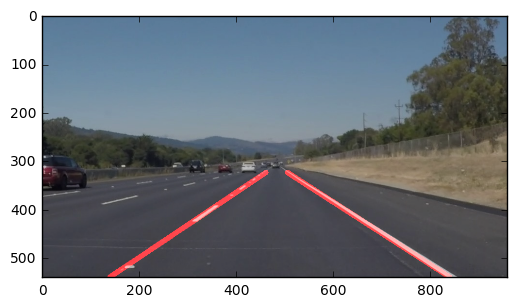

In [4]:
# Test on images
test_image1 = mpimg.imread('test_images/solidWhiteRight.jpg')
plt.imshow(process_image(test_image1))

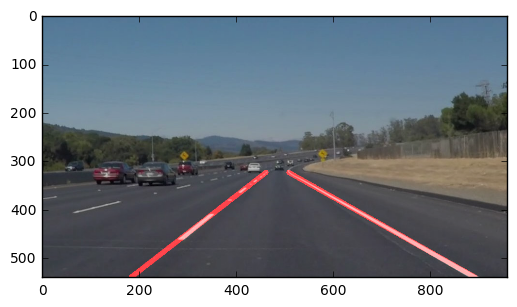

In [5]:
test_image2 = mpimg.imread('test_images/solidWhiteCurve.jpg')
plt.imshow(process_image(test_image2))

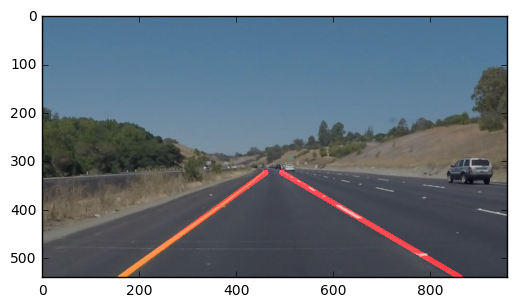

In [6]:
test_image3 = mpimg.imread('test_images/solidYellowCurve.jpg')
plt.imshow(process_image(test_image3))


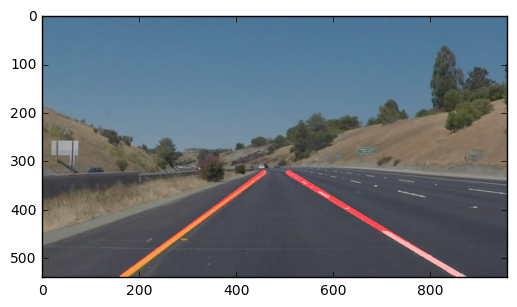

In [7]:
test_image4 = mpimg.imread('test_images/solidYellowCurve2.jpg')
plt.imshow(process_image(test_image4))

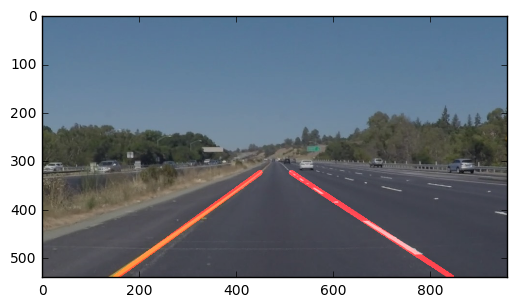

In [8]:
test_image5 = mpimg.imread('test_images/solidYellowLeft.jpg')
plt.imshow(process_image(test_image5))

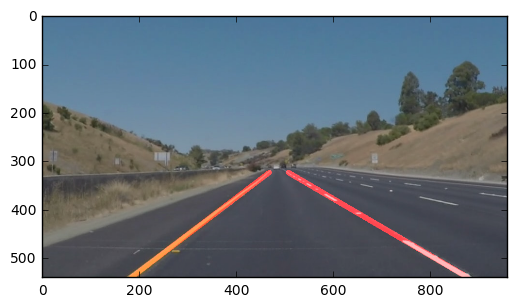

In [9]:
test_image6 = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
plt.imshow(process_image(test_image6))

Let's try the one with the solid white lane on the right first ...

In [10]:
# Apply to the video with the solid white lane on the right.
white_output = 'white.mp4'
clip1 = VideoFileClip('solidWhiteRight.mp4')
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:25<00:00,  8.68it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 4.93 s, sys: 1.55 s, total: 6.47 s
Wall time: 29 s


Play the video inline below.

In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left.

In [12]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [01:31<00:00, 11.62it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 15.6 s, sys: 4.82 s, total: 20.5 s
Wall time: 1min 33s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

My approach was to eliminate noise through a Gaussian blur, identify the edges using Canny edge detection, apply a Hough transform, and then find the line of best fit for those lines on the left or right side of the image (within certain bounds for the slope). This approach works fairly well for the two test videos, though the lane lines are jumpy, but it does not perform well for the challenge video below.

To improve it, I would focus on four potential areas, in this order:

- **Refining the parameters of the Hough transform through automated testing and evaluation.** Since there are few long(-ish), straight edges within the roadway other than the lane lines, the Hough transform has the potential to home in on the lane lines very effectively. With multiple parameters, there are many potential combinations of changes that could lead to more robust performance -- which made my tweak-and-test approach less than ideal. There may be a way to apply a more disciplined approach to identifying the optimal parameters in this case.

- **Eliminating outliers from the set of lines used to calculate the best fit lane lines.** When calculating the line of best fit, I included any lane lines between 0.1 and 0.9 (pos or neg) slope that were on the left or right side of the image. Lines that are outside, say, a full standard deviation from the average slope, however, could be thrown out of the data before doing this calculation. This approach would require looping through the Hough transform lines twice, but that should not be very costly in this case. This should improve the accuracy of the lane lines and reduce some of the jumpiness.

- **Ensuring the mask covers the lanes as closely as possible.** To do this, I would want to consider the possible curve angles on the highway and determine the scope of where the lane lines could fall in front of the car. With that information, I could then tighten the mask to eliminate some of the extraneous lines such as the edge between the roadway and the grass.

- **Refining the Canny edge detection thresholds, particularly the upper threshold.** The lane lines are very bright compared to the roadway, even under a shadow or when over a lighter colored roadway (e.g., the bridge in the challenge). There may be better parameters to use in this case to avoid identifying so many additional edges in the iamge.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [14]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [01:04<00:00,  5.99it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 11.7 s, sys: 3.26 s, total: 14.9 s
Wall time: 1min 9s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))